In [1]:
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

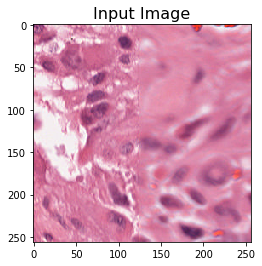

In [2]:
input_image_file = ('/home/raj/github/glioma_histo_img_classifier_lob/images/TCGA-02-0001-01Z-00-DX2_20x_832_29856_256x256.png')
                     # Easy1.png

im_input = skimage.io.imread(input_image_file)[:, :, :3]

plt.imshow(im_input)
_ = plt.title('Input Image', fontsize=16)

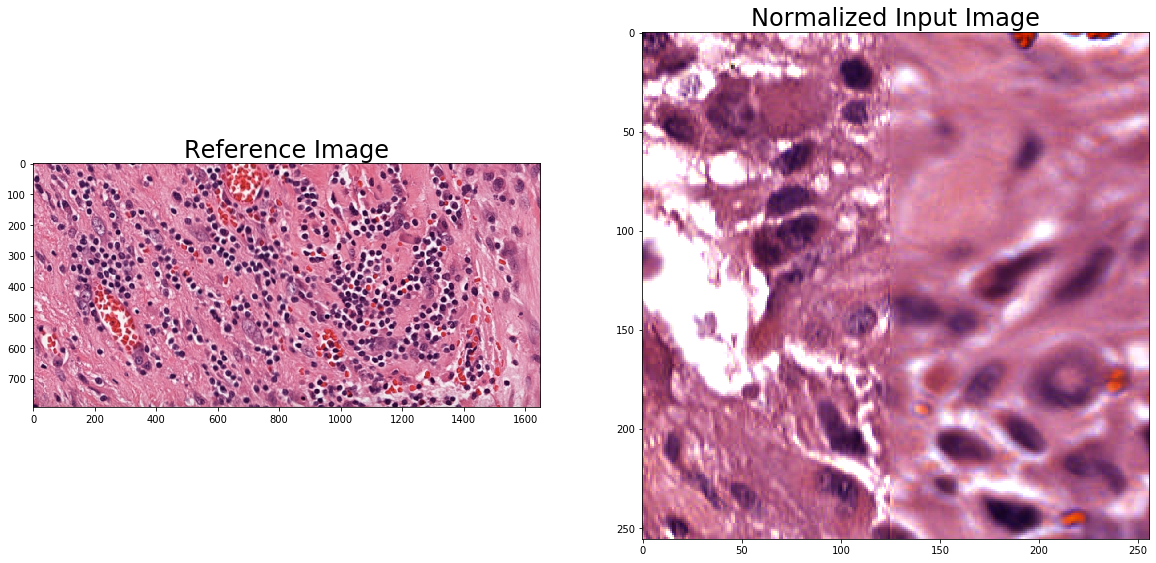

In [3]:
# Load reference image for normalization
ref_image_file = ('https://data.kitware.com/api/v1/file/'
                  '57718cc28d777f1ecd8a883c/download')  # L1.png

im_reference = skimage.io.imread(ref_image_file)[:, :, :3]

# get mean and stddev of reference image in lab space
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)

# perform reinhard color normalization
im_nmzd = htk.preprocessing.color_normalization.reinhard(im_input, mean_ref, std_ref)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_reference)
_ = plt.title('Reference Image', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_nmzd)
_ = plt.title('Normalized Input Image', fontsize=titlesize)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
gray = rgb2gray(im_nmzd)

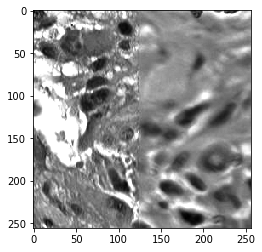

In [5]:
plt.imshow(gray, cmap = plt.get_cmap('gray'))

#plt.savefig('lena_greyscale.png')
plt.show()

In [6]:
import numpy as np


def graycomatrixext(im_input, im_roi_mask=None,
                    offsets=None, num_levels=None, gray_limits=None,
                    symmetric=False, normed=False, exclude_boundary=False):
    """Computes gray-level co-occurence matrix (GLCM) within a region of
    interest (ROI) of an image. GLCM is a 2D histogram/matrix containing the
    counts/probabilities of co-occuring intensity values at a given offset
    within an ROI of an image.
    Read the documentation to know the default values used for each of the
    optional parameter in different scenarios.
    Parameters
    ----------
    im_input : array_like
        Input single channel intensity image
    im_roi_mask : array_like, optional
        A binary mask specifying the region of interest within which
        to compute the GLCM. If not specified GLCM is computed for the
        the entire image.
        Default: None
    offsets : array_like, optional
        A (num_offsets, num_image_dims) array of offset vectors
        specifying the distance between the pixel-of-interest and
        its neighbor. Note that the first dimension corresponds to
        the rows.
        Because this offset is often expressed as an angle, the
        following table lists the offset values that specify common
        angles for a 2D image, given the pixel distance D.
        ===========  =============
        Angle (deg)  offset [y, x]
        ===========  =============
        0            [0 D]
        45           [-D D]
        90           [-D 0]
        135          [-D -D]
        ===========  =============
        Default
        - 1D: np.array([1])
        - 2D : numpy.array([ [1, 0], [0, 1], [1, 1], [1, -1] ])
        - 3D and higher: numpy.identity(num_image_dims)
    num_levels : unsigned int, optional
        An integer specifying the number of gray levels For example, if
        `NumLevels` is 8,  the intensity values of the input image are
        scaled so they are integers between 1 and 8.  The number of gray
        levels determines the size of the gray-level co-occurrence matrix.
        Default: 2 for binary/logical image, 32 for numeric image
    gray_limits : array_like, optional
        A two-element array specifying the desired input intensity range.
        Intensity values in the input image will be clipped into this range.
        Default: [0, 1] for boolean-valued image, [0, 255] for integer-valued
        image, and [0.0, 1.0] for-real valued image
    symmetric : bool, optional
        A boolean value that specifies whether or not the ordering of values
        in pixel pairs is considered while creating the GLCM matrix.
        For example, if `Symmetric` is True, then while calculating the
        number of times the value 1 is adjacent to the value 2, both
        1,2 and 2,1 pairings are counted. GLCM created in this way is
        symmetric across its diagonal.
        Default: False
    normed : bool, optional
        A boolean value specifying whether or not to normalize glcm.
        Default: False
    exclude_boundary : bool, optional
        Specifies whether or not to exclude a pixel-pair if the
        neighboring pixel in the pair is outside `im_roi_mask`.
        Has an effect only when `im_roi_mask` is specified.
        Default: False
    Returns
    -------
    glcm : array_like
        num_levels x num_levels x num_offsets array containing the GLCM
        for each offset.
    References
    ----------
    .. [#] Haralick, R.M., K. Shanmugan, and I. Dinstein, "Textural Features
       for Image Classification", IEEE Transactions on Systems, Man, and
       Cybernetics, Vol. SMC-3, 1973, pp. 610-621.
    .. [#] Haralick, R.M., and L.G. Shapiro. Computer and Robot Vision:
       Vol. 1, Addison-Wesley, 1992, p. 459.
    """

    num_dims = len(im_input.shape)

    # roi mask
    if im_roi_mask is None:

        # compute glcm for whole input image
        im_roi_mask = np.ones_like(im_input, dtype='bool')

    if im_input.shape != im_roi_mask.shape:
        raise ValueError('size mismatch between input image and roi mask')

    # gray_limits
    if gray_limits is None:

        gray_limits = _default_gray_limits(im_input)

    assert(len(gray_limits) == 2 and gray_limits[0] < gray_limits[1])

    # num_levels
    if num_levels is None:

        num_levels = _default_num_levels(im_input)

    # offsets
    if offsets is None:

        # set default offset value
        offsets = _default_offsets(im_input)

    else:

        # check sanity
        if offsets.shape[1] != num_dims:
            raise ValueError(
                'Dimension mismatch between input image and offsets'
            )

    num_offsets = offsets.shape[0]

    # scale input intensity image
    im_input = im_input.astype('float')
    im_input -= gray_limits[0]
    im_input /= np.float(gray_limits[1] - gray_limits[0])
    im_input *= (num_levels - 1)
    im_input = np.round(im_input).astype('int')

    # compute glcm for each offset
    glcm = np.zeros((num_levels, num_levels, num_offsets))

    im_input_flat = np.ravel(im_input)

    im_roi_mask_flat = np.ravel(im_roi_mask)

    roi_coord_ind = np.nonzero(im_roi_mask)

    roi_lin_ind = np.ravel_multi_index(roi_coord_ind, im_roi_mask.shape)

    for i in range(num_offsets):

        # compute indices of neighboring pixels by applying the offset
        neigh_coord_ind = [None] * len(roi_coord_ind)

        for j in range(num_dims):
            neigh_coord_ind[j] = roi_coord_ind[j] + offsets[i, j]

        # throw out pixels with invalid neighbors
        neigh_valid = np.ones_like(neigh_coord_ind[0], dtype='bool')

        for j in range(num_dims):

            neigh_valid[neigh_coord_ind[j] < 0] = False
            neigh_valid[neigh_coord_ind[j] >= im_roi_mask.shape[j]] = False

        for j in range(num_dims):
            neigh_coord_ind[j] = np.compress(neigh_valid, neigh_coord_ind[j],
                                             axis=0).astype(np.int64)

        neigh_lin_ind = np.ravel_multi_index(neigh_coord_ind,
                                             im_roi_mask.shape)

        if exclude_boundary:
            neigh_valid[im_roi_mask_flat[neigh_lin_ind] == 0] = False
            neigh_lin_ind = np.compress(neigh_valid, neigh_lin_ind, axis=0)

        valid_roi_lin_ind = np.compress(neigh_valid, roi_lin_ind, axis=0)

        # get intensities of pixel pairs which become coord indices in glcm
        p1 = np.take(im_input_flat, valid_roi_lin_ind, axis=0)
        p2 = np.take(im_input_flat, neigh_lin_ind, axis=0)

        # convert pixel-pair values to linear indices in glcm
        pind = np.ravel_multi_index((p1, p2), glcm.shape[:2])

        # find unique linear indices and their counts
        pind, pcount = np.unique(pind, return_counts=True)

        # put count of each linear index in glcm
        cur_glcm = np.zeros((num_levels, num_levels))
        cur_glcm_flat = np.ravel(cur_glcm)
        cur_glcm_flat[pind] = pcount

        # symmetricize if asked for
        if symmetric:
            cur_glcm += cur_glcm.T

        # normalize if asked
        if normed:
            cur_glcm /= cur_glcm.sum()

        glcm[:, :, i] = cur_glcm

    return glcm


def _default_gray_limits(im_input):

    assert(isinstance(im_input, np.ndarray))

    if np.issubdtype(im_input.dtype, np.bool_):

        gray_limits = [0, 1]

    elif np.issubdtype(im_input.dtype, np.integer):

        gray_limits = [0, 255]

    elif np.issubdtype(im_input.dtype, np.floating):

        gray_limits = [0.0, 1.0]

    else:

        raise ValueError('The type of the argument im_input is invalid')

    return gray_limits


def _default_num_levels(im_input):

    assert(isinstance(im_input, np.ndarray))

    if np.issubdtype(im_input.dtype, np.bool_):

        num_levels = 2

    elif np.issubdtype(im_input.dtype, np.number):

        num_levels = 32

    else:

        raise ValueError('The type of the argument im_input is invalid')

    return num_levels


def _default_offsets(im_input):

    num_dims = len(im_input.shape)

    if num_dims == 2:

        offsets = np.array([
            [0, 1], [1, 0], [1, 1], [1, -1]
        ])

    else:

        # TODO: need to come up with a better strategy for 3D and higher
        offsets = np.identity(num_dims)

    return offsets

In [7]:
gray = gray.astype(int)

In [8]:
gray.shape

(256, 256)

In [9]:
gray_glcm=graycomatrixext(gray)

ValueError: invalid entry in coordinates array

In [ ]:
gray_glcm.shape

In [ ]:
import numpy as np
import numpy as np
def compute_marginal_glcm_probs(nGLCM) :
    num_levels = nGLCM.shape[0]
    px = np.zeros([num_levels], dtype=np.float)
    py = np.zeros([num_levels], dtype=np.float)
    pxPlusy = np.zeros([2*num_levels-1], dtype=np.float)
    pxMinusy = np.zeros([num_levels], dtype=np.float)
    for i in range(num_levels):
        for j in range(num_levels):
            px[i] = px[i] + nGLCM[i, j]
            py[i]= py[i] + nGLCM[j, i]
            pxPlusy[i+j] = pxPlusy[i+j] + nGLCM[i, j]
            i_minus_j = i-j
            if i < j:i_minus_j *= -1
            pxMinusy[i_minus_j] = pxMinusy[i_minus_j] + nGLCM[i, j]
    return np.asarray(px), np.asarray(py), np.asarray(pxPlusy), np.asarray(pxMinusy)

In [ ]:
gray_glcm1=gray_glcm[:,:,0]

In [ ]:
x1,x2,x3,x4=compute_marginal_glcm_probs(gray_glcm1)

In [ ]:
x1.shape,x2.shape,x3.shape,x4.shape

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import numpy as np
import pandas as pd
#from skimage.measure import regionprops

def compute_haralick_features(im_intensity):
     # List of feature names
    feature_list = [
        'Haralick.Angle',
        'Haralick.ASM',
        'Haralick.Contrast',
        'Haralick.Correlation',
        'Haralick.SumOfSquares',
        'Haralick.IDM',
        'Haralick.SumAverage',
        'Haralick.SumVariance',
        'Haralick.SumEntropy',
        'Haralick.Entropy',
        'Haralick.DifferenceVariance',
        'Haralick.DifferenceEntropy',
        'Haralick.IMC1',
        'Haralick.IMC2',
    ]

    agg_feature_list = []
    for fname in feature_list:
        agg_feature_list.append(fname + '.Mean')
        agg_feature_list.append(fname + '.Range')
     # num_levels
    num_levels = 32
   # fdata = pd.DataFrame(columns=feature_list)
    n_Minus = np.arange(num_levels)
    n_Plus = np.arange(2 * num_levels - 1)

    x, y = np.mgrid[0:num_levels, 0:num_levels]
    xy = x * y
    xy_IDM = 1. / (1 + np.square(x - y))

    e = 0.00001  # small positive constant to avoid log 0
    arrayGLCM = graycomatrixext(im_intensity, offsets=None,
                                    num_levels=num_levels,
                                    gray_limits=None,
                                    symmetric=True, normed=True)
    
        # Compute haralick features for each offset
    #ldata = pd.DataFrame(np.zeros((num_offsets, len(feature_list))),columns=feature_list)
    num_offsets=4
    # Compute haralick features for each offset
    ldata = pd.DataFrame(np.zeros((num_offsets, len(feature_list))),columns=feature_list)

    for r in range(num_offsets):

            nGLCM = arrayGLCM[:, :, r]
            
            # get marginal-probabilities
            px, py, pxPlusy, pxMinusy = compute_marginal_glcm_probs(nGLCM)
            # computes angular second moment
            if(r==0):ang=0
            if(r==1):ang=45
            if(r==2):ang=90
            if(r==3):ang=135
                
            ldata.at[r, 'Haralick.Angle'] = ang
            
            ldata.at[r, 'Haralick.ASM'] =np.sum(np.square(nGLCM))

            # computes contrast
            ldata.at[r, 'Haralick.Contrast'] = \
                np.dot(np.square(n_Minus), pxMinusy)

            # computes correlation
            # gets weighted mean and standard deviation of px and py
            meanx = np.dot(n_Minus, px)
            variance = np.dot(px, np.square(n_Minus)) - np.square(meanx)
            nGLCMr = np.ravel(nGLCM)
            ldata.at[r, 'Haralick.Correlation'] = \
                (np.dot(np.ravel(xy), nGLCMr) - np.square(meanx)) / variance

            # computes sum of squares : variance
            ldata.at[r, 'Haralick.SumOfSquares'] = variance

            # computes inverse difference moment
            ldata.at[r, 'Haralick.IDM'] = \
                np.dot(np.ravel(xy_IDM), nGLCMr)

            # computes sum average
            ldata.at[r, 'Haralick.SumAverage'] = \
                np.dot(n_Plus, pxPlusy)

            # computes sum variance
            # [1] uses sum entropy, but we use sum average
            ldata.at[r, 'Haralick.SumVariance'] = \
                np.dot(np.square(n_Plus), pxPlusy) - \
                np.square(ldata.at[r, 'Haralick.SumAverage'])

            # computes sum entropy
            ldata.at[r, 'Haralick.SumEntropy'] = \
                -np.dot(pxPlusy, np.log2(pxPlusy+e))

            # computes entropy
            ldata.at[r, 'Haralick.Entropy'] = \
                -np.dot(nGLCMr, np.log2(nGLCMr+e))

            # computes variance px-y
            ldata.at[r, 'Haralick.DifferenceVariance'] = np.var(pxMinusy)

            # computes difference entropy px-y
            ldata.at[r, 'Haralick.DifferenceEntropy'] = \
                -np.dot(pxMinusy, np.log2(pxMinusy+e))

            # computes information measures of correlation
            # gets entropies of px and py
            HX = -np.dot(px, np.log2(px+e))
            HY = -np.dot(py, np.log2(py+e))
            HXY = ldata.at[r, 'Haralick.Entropy']
            pxy_ij = np.outer(px, py)
            pxy_ijr = np.ravel(pxy_ij)
            HXY1 = -np.dot(nGLCMr, np.log2(pxy_ijr+e))
            HXY2 = -np.dot(pxy_ijr, np.log2(pxy_ijr+e))
            ldata.at[r, 'Haralick.IMC1'] = (HXY-HXY1)/max(HX, HY)

            # computes information measures of correlation
            ldata.at[r, 'Haralick.IMC2'] = \
                np.sqrt(1 - np.exp(-2.0*(HXY2-HXY)))
   

    return ldata


            
  

In [ ]:
compute_haralick_features(gray)